In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import BytesIO

Kolumny w df_percentiles: Index(['Age', 'L', 'M', 'S', 'P01', 'P1', 'P3', 'P5', 'P10', 'P15', 'P25',
       'P50', 'P75', 'P85', 'P90', 'P95', 'P97', 'P99', 'P999'],
      dtype='object')
Kolumny w df_z_scores: Index(['Day', 'L', 'M', 'S', 'SD4neg', 'SD3neg', 'SD2neg', 'SD1neg', 'SD0',
       'SD1', 'SD2', 'SD3', 'SD4'],
      dtype='object')
Wybierz rodzaj siatki: 
1. Percentiles
2. Z-Score


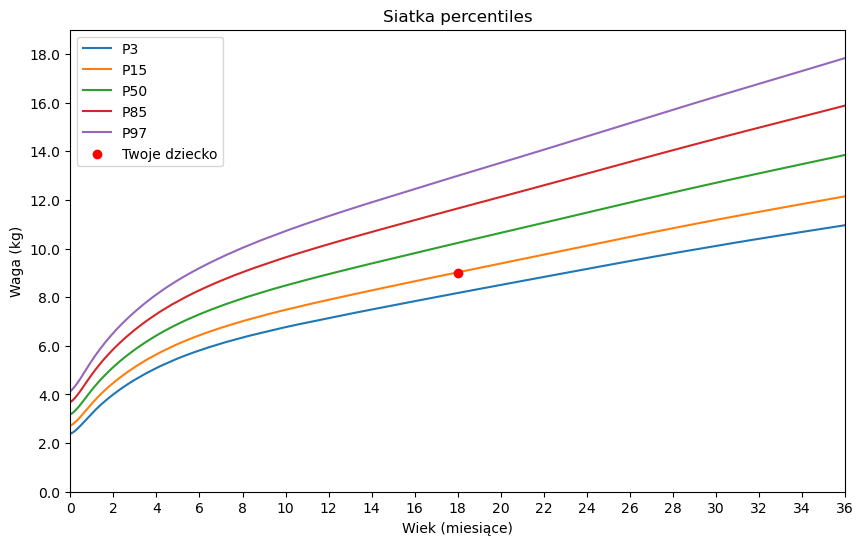

In [4]:
# URL do plików
url_percentiles = 'https://cdn.who.int/media/docs/default-source/child-growth/child-growth-standards/indicators/weight-for-age/expanded-tables/wfa-girls-percentiles-expanded-tables.xlsx?sfvrsn=54cfa5e8_9'
url_z_scores = 'https://cdn.who.int/media/docs/default-source/child-growth/child-growth-standards/indicators/weight-for-age/expanded-tables/wfa-girls-zscore-expanded-tables.xlsx?sfvrsn=f01bc813_10'

# Pobieranie danych
response_percentiles = requests.get(url_percentiles)
response_z_scores = requests.get(url_z_scores)

# Wczytanie danych z użyciem BytesIO
df_percentiles = pd.read_excel(BytesIO(response_percentiles.content))
df_z_scores = pd.read_excel(BytesIO(response_z_scores.content))

# Sprawdzenie dostępnych kolumn
print("Kolumny w df_percentiles:", df_percentiles.columns)
print("Kolumny w df_z_scores:", df_z_scores.columns)

# Użycie odpowiedniej kolumny dla wieku
wiek_kolumna = 'Age' if 'Age' in df_percentiles.columns else 'Day'
df_percentiles[wiek_kolumna] = df_percentiles[wiek_kolumna] / 30.44

wiek_kolumna = 'Age' if 'Age' in df_z_scores.columns else 'Day'
df_z_scores[wiek_kolumna] = df_z_scores[wiek_kolumna] / 30.44

# Zmieniamy nazwę kolumny na 'Age' dla spójności
df_percentiles.rename(columns={wiek_kolumna: 'Age'}, inplace=True)
df_z_scores.rename(columns={wiek_kolumna: 'Age'}, inplace=True)

def wybierz_siatke():
    print("Wybierz rodzaj siatki: \n1. Percentiles\n2. Z-Score")
    wybor = input("Wpisz 1 lub 2: ")
    if wybor == '1':
        return 'percentiles'
    elif wybor == '2':
        return 'z-score'
    else:
        print("Niepoprawny wybór. Spróbuj ponownie.")
        return wybierz_siatke()

def wprowadz_dane():
    waga = float(input("Podaj wagę dziecka (w kg): "))
    wiek = int(input("Podaj wiek dziecka (w miesiącach): "))
    return waga, wiek

def znajdz_pozycje(df, wiek, waga, rodzaj_siatki):
    # Znajdowanie najbliższego wieku w DataFrame
    najblizszy_wiek_idx = (df['Age'] - wiek).abs().idxmin()  # Znajdź indeks najbliższego wieku
    najblizszy_wiek_row = df.iloc[najblizszy_wiek_idx]  # Pobierz wiersz z DataFrame dla tego indeksu

    if rodzaj_siatki == 'percentiles':
        for centyl in ['P3', 'P15', 'P50', 'P85', 'P97']:
            if waga <= najblizszy_wiek_row[centyl]:
                return centyl
        return 'P97'  # Jeśli waga jest wyższa niż P97, przyjmij P97 jako najbliższy (lub inna logika)
    elif rodzaj_siatki == 'z-score':
        # Lista z-scores od najniższego do najwyższego
        z_scores = ['SD4neg', 'SD3neg', 'SD2neg', 'SD1neg', 'SD0', 'SD1', 'SD2', 'SD3', 'SD4']
        for i, sd in enumerate(z_scores):
            if waga <= najblizszy_wiek_row[sd]:
                return sd if i != 0 else 'Poniżej SD4neg'
        return 'Powyżej SD4'
    return None # W przypadku, gdy nie znaleziono pasującej pozycji

def rysuj_wykres(df, wiek, waga, rodzaj_siatki, pozycja):
    if pozycja is None:
        print("Nie można znaleźć pozycji dla podanych danych.")
        return  # Zakończ funkcję, jeśli nie znaleziono pozycji

    plt.figure(figsize=(10, 6))
    df = df.sort_values(by='Age')
    df_filtered = df[df['Age'] <= 36]
    if rodzaj_siatki == 'percentiles':
        centyle = ['P3', 'P15', 'P50', 'P85', 'P97']
        for centyl in centyle:
            plt.plot(df_filtered['Age'], df_filtered[centyl], label=f'{centyl}')
    elif rodzaj_siatki == 'z-score':
        z_scores = ['SD4neg', 'SD3neg', 'SD2neg', 'SD1neg', 'SD0', 'SD1', 'SD2', 'SD3', 'SD4']
        for sd in z_scores:
            plt.plot(df_filtered['Age'], df_filtered[sd], label=f'{sd}')

    # Dodaj punkt dla danych dziecka
    plt.scatter(wiek, waga, color='red', zorder=5, label='Twoje dziecko')

    plt.xlabel('Wiek (miesiące)')
    plt.ylabel('Waga (kg)')
    plt.title(f'Siatka {rodzaj_siatki}')
    plt.xlim(0, 36)  # Ustawienie zakresu osi X
    plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36], ['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32', '34', '36'])
    plt.ylim(0, 19)
    plt.yticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0], ['0.0', '2.0', '4.0', '6.0', '8.0', '10.0', '12.0', '14.0', '16.0', '18.0'])
    plt.legend()
    plt.show()

# Integracja funkcji
def main():
    rodzaj_siatki = wybierz_siatke()
    waga, wiek = wprowadz_dane()
    if rodzaj_siatki == 'percentiles':
        df = df_percentiles
    elif rodzaj_siatki == 'z-score':
        df = df_z_scores
    pozycja = znajdz_pozycje(df, wiek, waga, rodzaj_siatki)
    rysuj_wykres(df, wiek, waga, rodzaj_siatki, pozycja)

if __name__ == "__main__":
    main()